In [7]:
import sys
import os
sys.path.insert(0, '/home/jlaura/github/autocnet')
import autocnet.examples as ex
import autocnet.fileio.io_spectral_profiler as sp
import autocnet.spectral.smoothing as sm
import pandas as pd
from autocnet.examples import get_path

import matplotlib.image as mpimg
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Input data
In the next cell, set the input data.  This is the `.spc` data file and the browse thumbnail jpg (the smaller of the two).

In [8]:
input_data = get_path('SP_2C_02_02358_S138_E3586.spc')
input_image = get_path('SP_2C_02_02358_S138_E3586.jpg') 

# Visualize over the base
This next cell visualizes the data points over the basemap

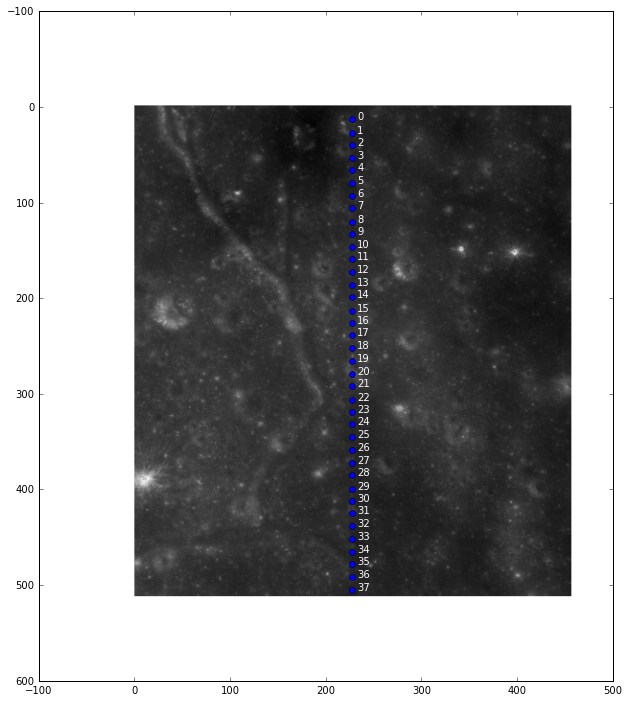

In [9]:
figsize(12,12)
#Input data set here
 #or None

s = sp.Spectral_Profiler(input_data)
#Compute the locations where the observations were captured
line = s.ancillary_data['THUMBNAIL_LINE_POSITION'] # SUPPORT_IMAGE_LINE_POSITION
column = s.ancillary_data['THUMBNAIL_COLUMN_POSITION'] # SUPPORT_IMAGE_COLUMN_POSITION

#Plot the image with the labeled observation points
img=mpimg.imread(input_image)
imshow(img, cmap='gist_gray')
plot(column, line, 'bo')  
f = plt.gcf()
ax = f.axes[0]

for i, txt in enumerate(range(len(column))):
    ax.annotate(txt, (column[i] + 5,line[i]), color='white')

# Plot raw spectra
This next cell allows one to specify which spectra to extract and then visualize.

The line(s) `m14 = s.spectra[14]['Highlands']` assigns the m14 variable with the Highland corrected spectra at point number 14.

The line(s) `m14.plot(label='14')` generates the plot with the data labeled 14.

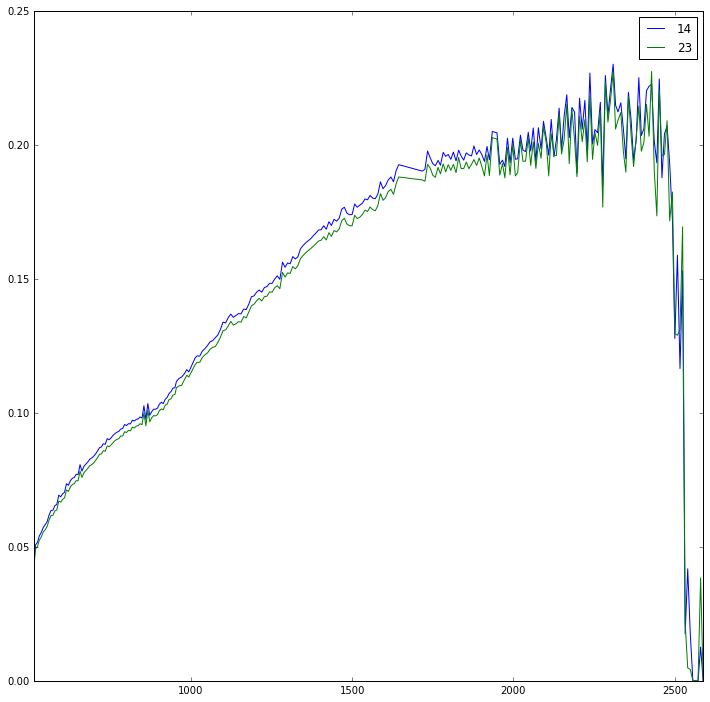

In [10]:
#Plot the raw spectra
m14 = s.spectra[14]['Highlands']
m23 = s.spectra[23]['Highlands']
m14.plot(label='14')
m23.plot(label='23')
legend(loc='best')

# Continuum Correct
A piecewise linear continuum is fit, in the next cell, through 3 nodes (722.7, 1475.8, and 2420.2).  Fitting a continuum returns the corrected spectrum (`cor14`) and the continuum line (`cont14`).

In [11]:
#Continuum Correct the spectrum
cor14, cont14 = m14.continuum_correct(method='linear', nodes=[722.7, 1475.8, 2420.2])
cor23, cont23 = m23.continuum_correct(method='linear', nodes=[722.7, 1475.8, 2420.2])

# Points at which continuum can be fit
The next cell is just a listing of the wavelenghts at which the continuum can be fit.  These are the values that must be used as nodes for the fitting spline.

In [12]:
#What wavelengths are available?
m14.keys().values

array([  512.6,   518.4,   524.7,   530.4,   536.5,   542.8,   548.7,
         554.5,   560.5,   566.7,   572.6,   578.5,   584.5,   590.6,
         596.7,   602.5,   608.6,   614.6,   620.5,   626.7,   632.7,
         638.6,   644.6,   650.6,   656.6,   662.6,   668.8,   674.7,
         680.6,   686.7,   692.6,   698.6,   704.7,   710.8,   716.7,
         722.7,   728.7,   734.7,   740.7,   746.8,   752.8,   758.7,
         764.8,   770.7,   776.7,   782.7,   788.8,   794.7,   800.7,
         806.8,   812.7,   818.7,   824.8,   830.8,   836.8,   842.8,
         848.8,   854.6,   860.7,   866.7,   872.7,   878.7,   884.6,
         890.7,   896.6,   902.7,   908.7,   914.6,   920.6,   926.6,
         932.6,   938.6,   944.6,   950.6,   955.4,   963.5,   971.4,
         979.7,   987.6,   993.7,  1013.1,  1019.5,  1027.7,  1035.5,
        1043.6,  1051.7,  1059.7,  1067.8,  1075.8,  1083.6,  1091.8,
        1099.7,  1107.7,  1115.9,  1123.8,  1131.8,  1139.7,  1147.8,
        1155.7,  116

# Plotting
The continuum corrected spectra is plotted, first as point data (`cor14.plot(marker='o', line...`) and then with a boxcar filter applied (`cor14.boxcar_smooth().plot(color='g`).

Multiple spectra are being plotted.  Therefore, `cor23.values += 0.5` applies an offset to the second spectrum.

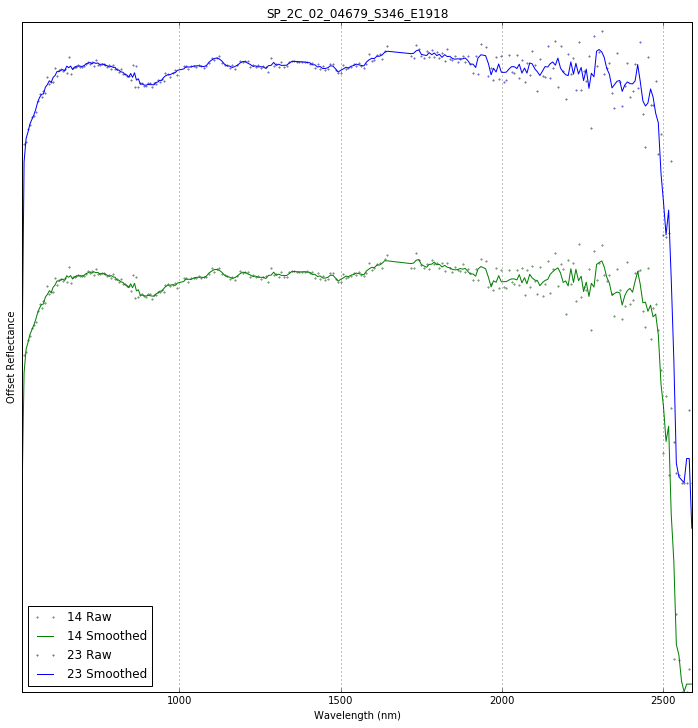

In [13]:
figsize(12,12)
cor14.plot(marker='o', linewidth=0, markersize=1.5, color='green', alpha=0.5,label='14 Raw')
cor14.boxcar_smooth().plot(color='green', label='14 Smoothed')

cor23.values += 0.5

cor23.plot(marker='o', linewidth=0, markersize=1.5, color='blue', alpha=0.5, label='23 Raw')
cor23.boxcar_smooth().plot(color='blue', label='23 Smoothed')
xlabel('Wavelength (nm)')
ylabel('Offset Reflectance')

gca().axes.get_yaxis().set_ticks([])
grid()
legend(loc='best')
title('SP_2C_02_04679_S346_E1918')

# Computing Band Center

Using `cor14` as an example, the band center is computed between two channels, 686.7 and 1620.1.

In [14]:
center, centerfit = cor14.band_center(686.7, 1620.1)
print(center)

(932.60000000000002, 0.97275767288966208)


# Plotting the Band Center
Now that the band center has been identified, it is plotable.  The cell below plots the raw, continuum corrected spectrum, the polynomial center fit (badly placed by me), and the computed band center (red star).

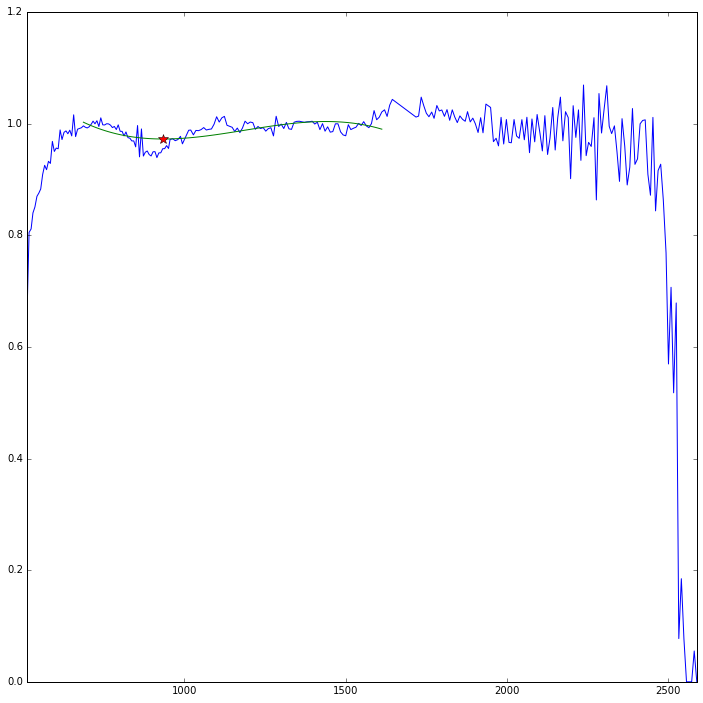

In [15]:
cor14.plot()
centerfit.plot()
plot(center[0], center[1], 'r*', markersize=10)

# Compute the band area
The next call computes the band area.

In [16]:
cor14.band_area()

-165.22139474197198

# Band Minima
Finally, the band minima is computed (and plotted in the subsequent cell).

In [17]:
minima = cor14.band_minima(1179.8, 1636.1)

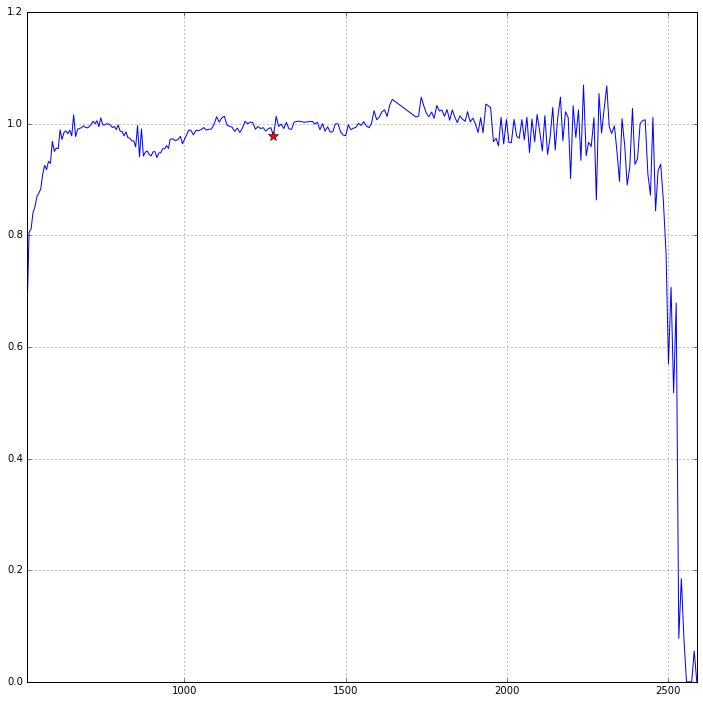

In [18]:
cor14.plot()
plot(minima[0], minima[1], 'r*', markersize=10)
grid()

# Clipping
The spectra plotted above look pretty bad because of all the noise.  These have all been cleaned via the QA, so this is 'good' data according to the label.  

To clip the data, it is easiest to create a new `Spectra`.  This is illustrated in the cell below.

In [19]:
clipped14 = cor14[:2029.3]

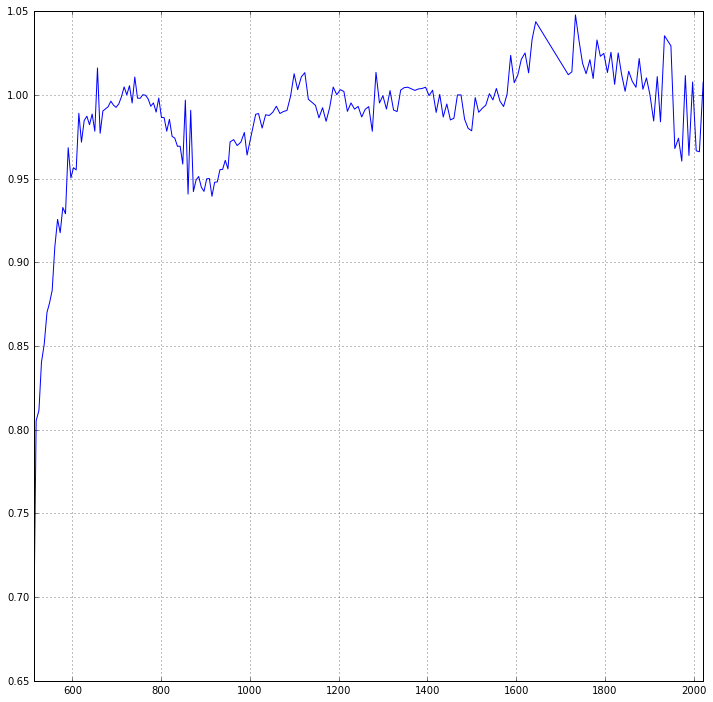

In [20]:
clipped14.plot()
grid()